<a href="https://colab.research.google.com/github/StevTobs/colab-connected/blob/main/windfarm_intregation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://drive.google.com/open?id=1Y4In3DMwgZgqpfW4oJPUDVBj86w_b91D

!pip install -U -q PyDrive  
 
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

your_module = drive.CreateFile({'id':'1Y4In3DMwgZgqpfW4oJPUDVBj86w_b91D'})
your_module.GetContentFile('cvxpower.py')
from cvxpower import *

In [ ]:

# !pip install -U -q PyDrive

# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# #Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # PyDrive reference:
# # https://gsuitedevs.github.io/PyDrive/docs/build/html/index.html


# # Initialize GoogleDriveFile instance with file id.
# file6 = drive.CreateFile({'id': '1c6ilwHdWjwNIO7Lp3IU_Gx4dw8Qzgv6q'})
# file6.GetContentFile('something.csv') # Download file as 'catlove.png'  

# import csv

# with open('something.csv') as csv_file:
#     csv_reader = csv.reader(csv_file, delimiter=',')
#     line_count = 0
#     for row in csv_reader:
#       print(row)


In [ ]:

!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


# import from google drive of cvxpower.py
your_module = drive.CreateFile({'id':'1Y4In3DMwgZgqpfW4oJPUDVBj86w_b91D'})
your_module.GetContentFile('cvxpower.py')
from cvxpower import *


# Wind farm integration

An example of a wind farm offering firm power by estimating the expected wind resource and then using a MPC to jointly optimize control of a small gas turbine and storage.

In [ ]:
%matplotlib inline
import datetime
import pandas as pd
import matplotlib
import numpy as np
import cvxpy as cvx
from matplotlib import pyplot as plt


matplotlib.rc("figure", figsize=(16,6))
matplotlib.rc("lines", linewidth=2)
#matplotlib.rc("font", serif='Computer Modern Roman')
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
matplotlib.rc('text', usetex=False)

graphdir = './'
figsize=(8,5)

## TODOs

- keep simplifying the code. it must become much easier to read!
- make a cell at the start with ALL the constants/parameters and their units!
- make better plot/comparisons
- test on two separate weeks? or on the whole year...

## Load predictive model 

In [ ]:
# https://drive.google.com/open?id=1H94dVDRT2Ct06-njEpx0VQU-saWaI-Dr
your_module = drive.CreateFile({'id':'1H94dVDRT2Ct06-njEpx0VQU-saWaI-Dr'})
your_module.GetContentFile('wind_baseline.pickle')
baseline = pd.read_pickle('wind_baseline.pickle')

# https://drive.google.com/open?id=1vHAlIed228y6FEIJqqSom48dV3vf4UC3
your_module = drive.CreateFile({'id':'1vHAlIed228y6FEIJqqSom48dV3vf4UC3'})
your_module.GetContentFile('residual_params.pickle')
autoreg_residual_params = pd.read_pickle('residual_params.pickle')

# https://drive.google.com/open?id=11M-ziM8MUeIk7tnTTStxVJ1l6cguVS6c
your_module = drive.CreateFile({'id':'11M-ziM8MUeIk7tnTTStxVJ1l6cguVS6c'})
your_module.GetContentFile('sigma_epsilon.pickle')
sigma_residual_errors = pd.read_pickle('sigma_epsilon.pickle')

# https://drive.google.com/open?id=1jpIaGrb4CNgEZ_0qN_MnaqmkPsp-K8eD
your_module = drive.CreateFile({'id':'1jpIaGrb4CNgEZ_0qN_MnaqmkPsp-K8eD'})
your_module.GetContentFile('wind_power_train.pickle')
train = pd.read_pickle('wind_power_train.pickle')

# https://drive.google.com/open?id=1vAral5RG8ZTIqJSe0_s5SKXH_lhdpZKH
your_module = drive.CreateFile({'id':'1vAral5RG8ZTIqJSe0_s5SKXH_lhdpZKH'})
your_module.GetContentFile('wind_power_test.pickle')
test = pd.read_pickle('wind_power_test.pickle')

p_wind = pd.concat([train,test])
del train
del test

## Set constants and test period

In [ ]:
!pip install latex
!pip3 install latex
!pip install -U matplotlib
!python -m pip install -U pip
!python -m pip install -U matplotlib
# !export CC=x86_64-pc-linux-gnu-gcc
# !export CXX=x86_64-pc-linux-gnu-g++
# !export PKG_CONFIG=x86_64-pc-linux-gnu-pkg-config

Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.3)
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (19.0.3)
Requirement already up-to-date: matplotlib in /usr/local/lib/python3.6/dist-packages (3.0.3)


/usr/local/lib/python3.6/dist-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


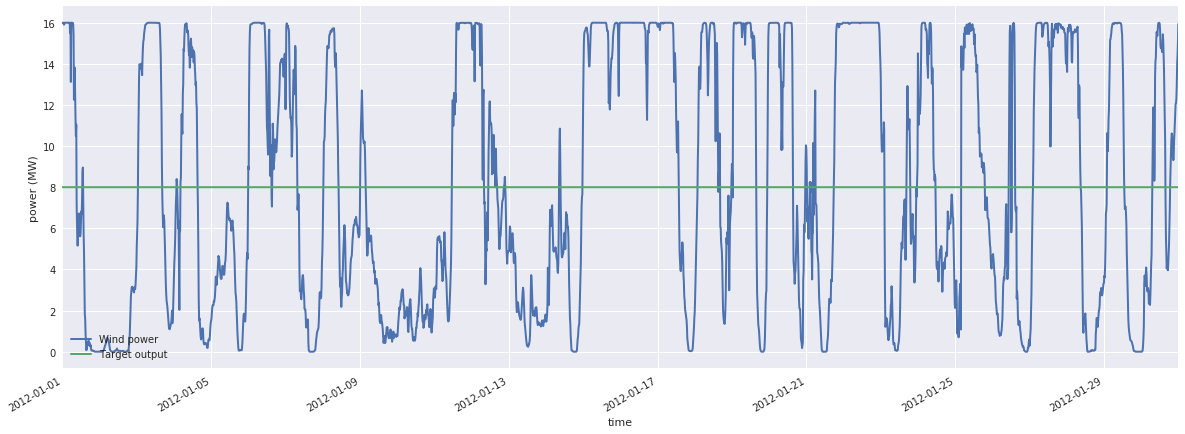

In [ ]:
# CONSTANTS
storage_capacity = 50 # MWh
initial_storage = storage_capacity // 2
battery_charge_max = storage_capacity /10. # a full charge in 10 hours
battery_discharge_max = storage_capacity /10. # a full discharge in 10 hours
wind_power_max = 16.  # TODO delete?
wind_power_min = 0.  # TODO delete?

gas_power_max = 12  #MW
gas_power_min = 0.01 #MW
gas_alpha = .5
gas_beta = 80.

# len of each time interval, in hours
len_interval = (baseline.index[1] - baseline.index[0]).seconds/3600
intervals_per_day = int(24 / len_interval)

# analysis horizon
T = intervals_per_day * 31

# we test on the first off-sample month
sim_start_time = 70080 # Timestamp('2012-01-01 00:00:00')
sim_end_time = sim_start_time + T

assert len(baseline) > sim_end_time
assert baseline.index[sim_start_time].year >= 2012 # out of sample

MPC_final_energy_price = 80 / len_interval


#wind_power_available = test[target_output.index]

target_output = pd.Series(data= 8., #baseline[sim_start_time:sim_end_time].mean(),
                          index=baseline[sim_start_time:sim_start_time + 2*T].index)

#p_wind[sim_start_time:sim_end_time].plot(figsize=(12,3), label='Wind power')
plt.figure(figsize=(20,10))
plt.subplot2grid((4,1), (0,0), rowspan=3)
y = p_wind[sim_start_time:sim_end_time]
plt.plot(y.index, y.values, label='Wind power')
target_output[:T].plot(label='Target output')
plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
plt.ylabel('power (MW)')
plt.xlabel('time')

plt.legend(loc='lower left')
plt.savefig('wind_data.pdf')

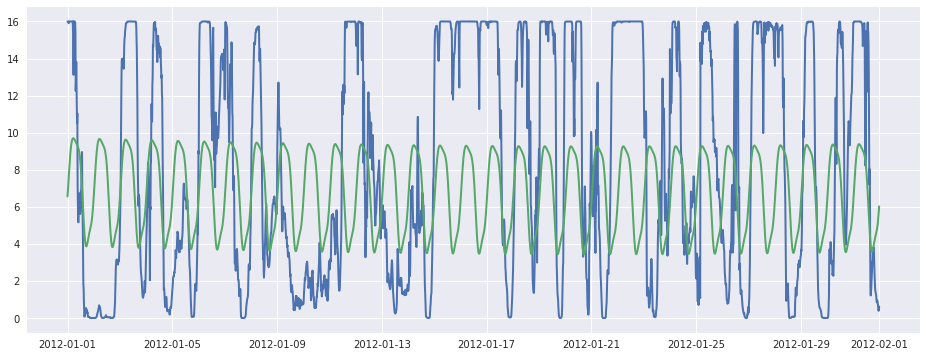

In [ ]:
plt.plot(p_wind[sim_start_time:sim_end_time])
plt.plot(baseline[sim_start_time:sim_end_time])

### Cost of MWh produced by gas turbine 

Text(0, 0.5, '\\$ / MWh')

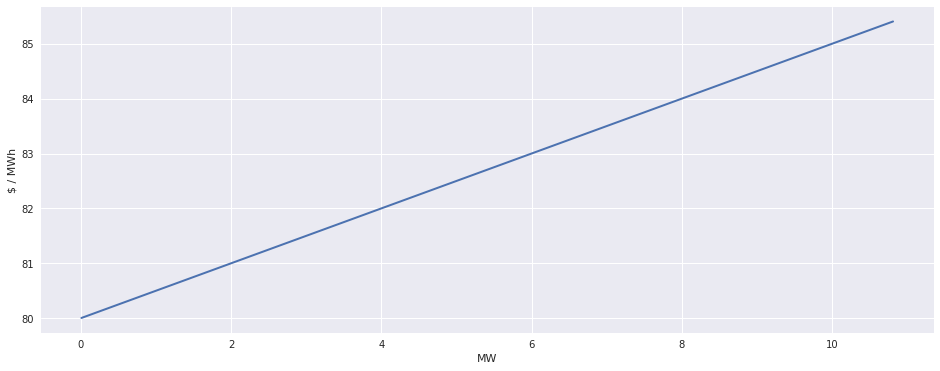

In [ ]:
def cost_per_unit(power):
    return (gas_alpha * power**2 + gas_beta * power)/power

x = np.arange(gas_power_min, gas_power_max, gas_power_max/10)
plt.plot(x, cost_per_unit(x))
plt.xlabel('MW')
plt.ylabel('\$ / MWh')

## Prescient DOPF

In [ ]:
def make_network(T, K):
    """Define network and parameters for data."""
    target_output = Parameter((T,K))
    wind_power_available = Parameter((T,K))
    initial_storage = Parameter((1,1))
    final_energy_price = Parameter((1,1))
    final_storage = Parameter((1,1))
    out = FixedLoad(power = target_output, name="Target output")
    wind_gen = Generator(alpha=0, beta=0, power_min=0, 
                         power_max=wind_power_available, name="Wind generator")
    gas_gen = Generator(alpha=gas_alpha, beta=gas_beta, 
                        power_min=gas_power_min, power_max=gas_power_max, name="Gas generator",
                       len_interval = len_interval)
    storage = Storage(discharge_max=battery_discharge_max, charge_max=battery_charge_max, 
                      energy_max=storage_capacity, 
                      energy_init = initial_storage, 
                      energy_final = final_storage,
                     len_interval = len_interval,
                     final_energy_price = final_energy_price)
    net = Net([wind_gen.terminals[0],
               gas_gen.terminals[0],
               storage.terminals[0],
               out.terminals[0]])
    dopf_network = Group([wind_gen, gas_gen, storage, out], [net])
    dopf_network.init_problem(time_horizon=T, num_scenarios = K)
    return target_output, wind_power_available, initial_storage, final_storage, final_energy_price, dopf_network

In [ ]:
from cvxpy import Parameter
target_output_par, wind_power_available_par, initial_storage_par, final_storage_par, final_energy_price, dopf_network = \
    make_network(T, 1)
    
target_output_par.value = np.matrix(target_output[:T]).T
wind_power_available_par.value = np.matrix(p_wind[sim_start_time:sim_end_time]).T
initial_storage_par.value = np.matrix(initial_storage)
final_storage_par.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(0.)

# cost_dopf = dopf_network.problem.solve(solver='ECOS', verbose=True)
print( p_wind[sim_start_time:sim_end_time])
print(type(p_wind[sim_start_time:sim_end_time]))
print( len(p_wind[sim_start_time:sim_end_time]))
print(T)


2012-01-01 00:00:00    15.998
2012-01-01 00:15:00    15.999
2012-01-01 00:30:00    15.998
2012-01-01 00:45:00    15.993
2012-01-01 01:00:00    15.907
2012-01-01 01:15:00    15.917
2012-01-01 01:30:00    16.000
2012-01-01 01:45:00    16.000
2012-01-01 02:00:00    16.000
2012-01-01 02:15:00    16.000
2012-01-01 02:30:00    16.000
2012-01-01 02:45:00    16.000
2012-01-01 03:00:00    16.000
2012-01-01 03:15:00    16.000
2012-01-01 03:30:00    16.000
2012-01-01 03:45:00    16.000
2012-01-01 04:00:00    16.000
2012-01-01 04:15:00    15.998
2012-01-01 04:30:00    15.992
2012-01-01 04:45:00    16.000
2012-01-01 05:00:00    15.500
2012-01-01 05:15:00    15.994
2012-01-01 05:30:00    13.121
2012-01-01 05:45:00    15.998
2012-01-01 06:00:00    16.000
2012-01-01 06:15:00    16.000
2012-01-01 06:30:00    15.993
2012-01-01 06:45:00    15.990
2012-01-01 07:00:00    15.939
2012-01-01 07:15:00    15.424
                        ...  
2012-01-31 16:30:00     1.618
2012-01-31 16:45:00     1.973
2012-01-3

In [ ]:
def print_and_plot_stats(wind_power_avail, wind_power_used, gas_power, output, cost):
    assert len(output) == len(wind_power_avail)
    assert len(output) == len(wind_power_used)
    assert len(output) == len(gas_power)

    plt.figure(figsize=(20,10))
    plt.subplot2grid((10,1), (0,0), rowspan=9)
    plt.plot(wind_power_avail.index, wind_power_avail.values, label='avail.', alpha=.8)
    pd.Series(data = wind_power_used, 
              index = wind_power_avail.index).plot(label='used', alpha=.8)
    #output.plot(label='target', style='--', color='k', alpha=.8)
    plt.legend(loc='lower left')
    plt.gca().set_xlim(['01-01-2012', '01-31-2012'])
    plt.ylabel('Power (MW)')
    plt.xlabel('time')
    #plt.gcf().autofmt_xdate()
    plt.savefig('wind_curtailment.pdf')

    total_output = sum(output)/len(output) 
    total_wind_power_avail = sum(wind_power_avail)/len(output)
    total_gas_gen = sum(gas_power)/len(output)

    print('(Values are daily averages.)\n')
    print('Energy sold:\t\t%.2f MWh\nWind energy avail.:\t%.2f MWh\nGas gener. output:\t%.2f MWh\nWind energy used:\t%.2f MWh\nWind energy lost:\t%.2f MWh' % (
        24*total_output,
        24*total_wind_power_avail,
        24*total_gas_gen,
        24*np.mean(wind_power_used),
        24*(total_wind_power_avail - np.mean(wind_power_used))
    ))

    print('\nEnergy sold (at $80/MWh):    $%.2f' % (24 * total_output *80))
    print('Cost of gas generated energy:  $%.2f' % (24 * cost / (len(output))))

(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	39.25 MWh
Wind energy used:	152.75 MWh
Wind energy lost:	49.61 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $3217.00


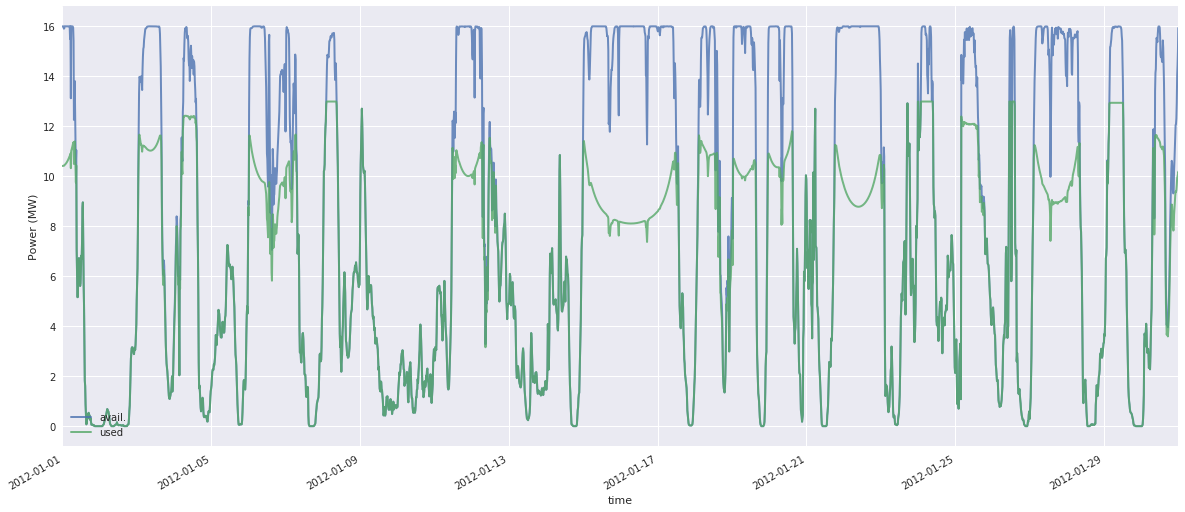

In [ ]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]


print_and_plot_stats(wind_power_avail = p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -dopf_network.results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -dopf_network.results.power[(gas_gen,0)], 
                     output = target_output[:T], 
                     cost = cost_dopf)

In [ ]:
def plot(results, target_output, energy_stored, methodname):
    ax = results.plot(figsize=(20,10), index=target_output.index)
    plt.subplots_adjust(hspace=0.075)
    ax[0].set_ylabel('power (MW)')
    ax[0].set_xlim(['01-01-2012', '01-31-2012'])
    ax[0].legend(['gen.', 'batt.', 'target', 'wind'], loc='lower left')
    ax[0].tick_params(axis="x", which="both", bottom="off", top="off",
                  labelbottom="off", left="off", right="off", labelleft="off")
    ax[1].clear() 
    ax[1].plot(target_output.index, energy_stored)
    ax[1].set_ylabel('Energy (MWh)')
    ax[1].set_xlim(['01-01-2012', '01-31-2012'])
    ax[1].set_ylim([0, 50])
    plt.xlabel('time')
    plt.savefig(graphdir+'wind_%s_results.pdf'%methodname)

ValueError: ignored

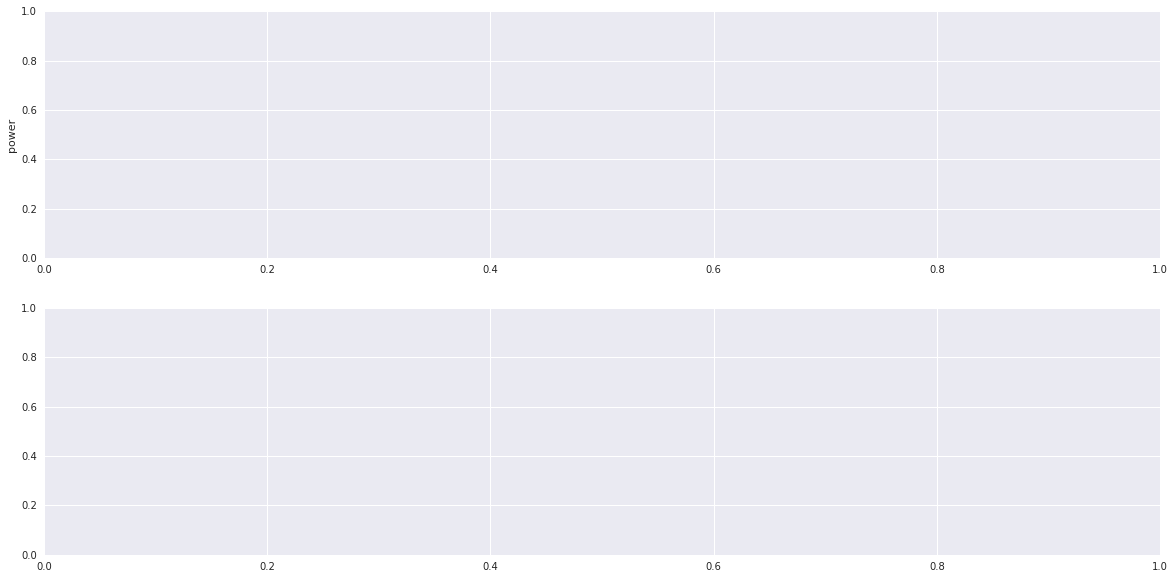

In [ ]:
wind_gen, gas_gen, storage = dopf_network.devices[0:3]

plot(dopf_network.results, baseline[sim_start_time:sim_end_time], storage.energy.value, 'dopf')

## Prescient MPC 

In [ ]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(p_wind[sim_start_time+t:sim_start_time+t+T_MPC]).T
    
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_prescient_MPC, prescient_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [04:49<00:00, 10.26it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	39.54 MWh
Wind energy used:	152.75 MWh
Wind energy lost:	49.61 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $3241.71


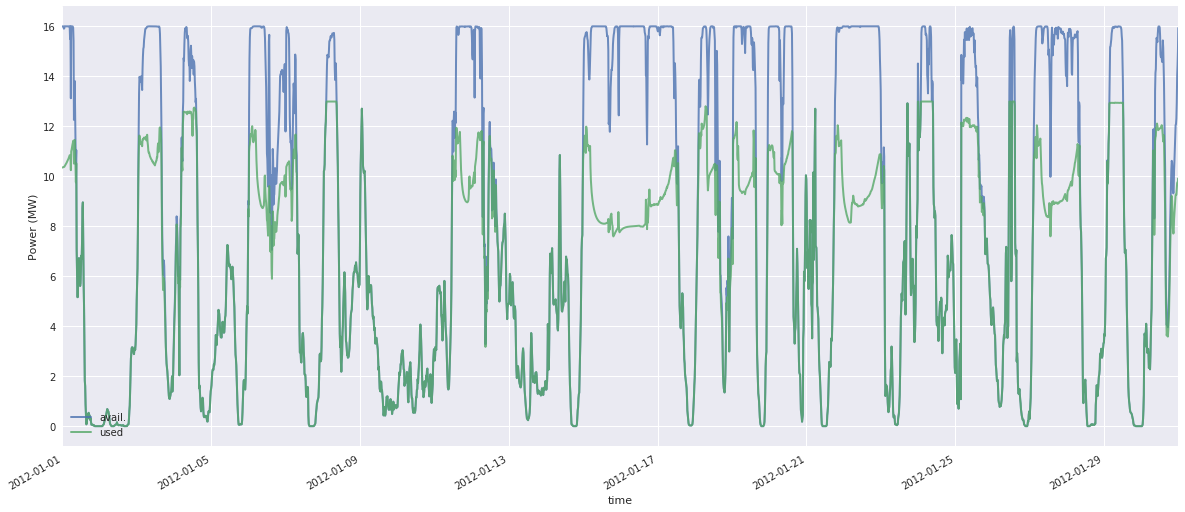

In [ ]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -prescient_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -prescient_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_prescient_MPC)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


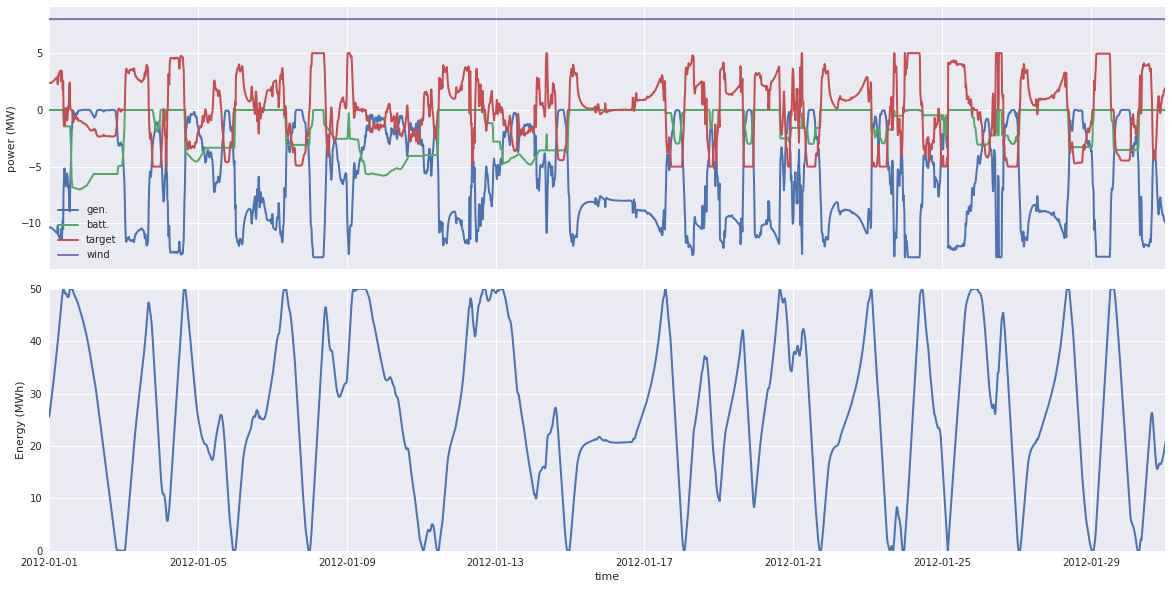

In [ ]:
plot(prescient_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'presc_mpc')

## MPC with baseline and residual AR

In [ ]:
T_MPC = intervals_per_day

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, 1)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)

def predict_wind(p_wind, baseline, autoreg_residual_params, t, M, L, K = 1):
    past = p_wind[t-M:t]
    past_baseline = baseline[t-M:t]
    fut_baseline = baseline[t:t+L]
    pred = list(reversed(past-past_baseline)) @ autoreg_residual_params
    pred = pd.Series(pred, index=fut_baseline.index)
    pred = np.maximum(wind_power_min, pred + fut_baseline)
    pred = np.minimum(wind_power_max, pred + fut_baseline)
    return pred

def make_forecasts(t):
    target_output_MPC.value = np.matrix(target_output[t:t+T_MPC]).T
    wind_power_available_MPC.value = np.matrix(np.concatenate([
        [p_wind[sim_start_time+t]],
        predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]])).T
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    #final_storage_MPC.value = np.matrix(energy_stored[t]) # change this to change MPC behavior
    
cost_AR_MPC, AR_MPC_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [06:12<00:00,  8.04it/s]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	52.78 MWh
Wind energy used:	138.41 MWh
Wind energy lost:	63.95 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $4386.24


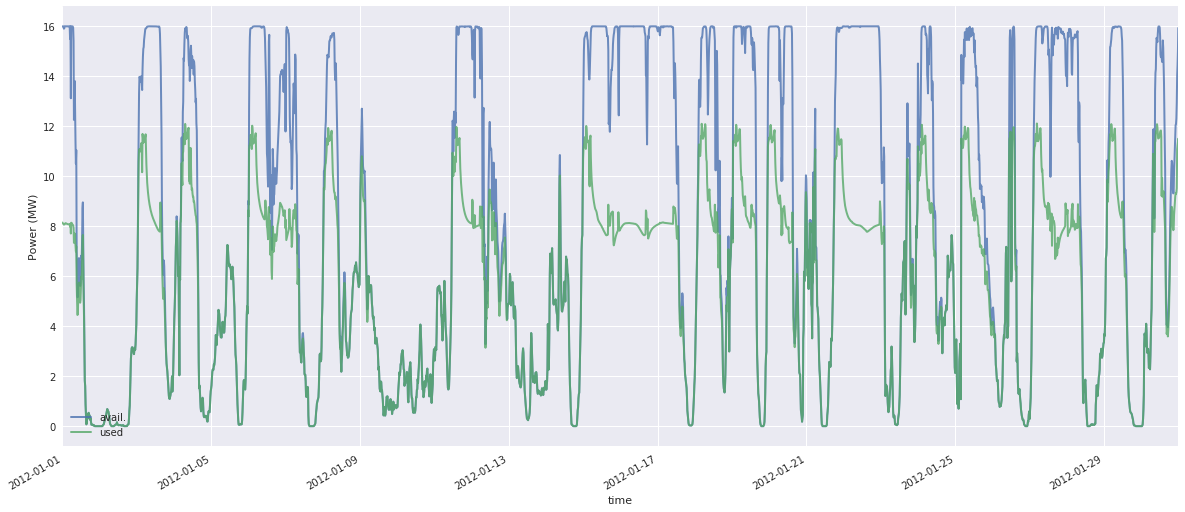

In [ ]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -AR_MPC_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -AR_MPC_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_AR_MPC)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


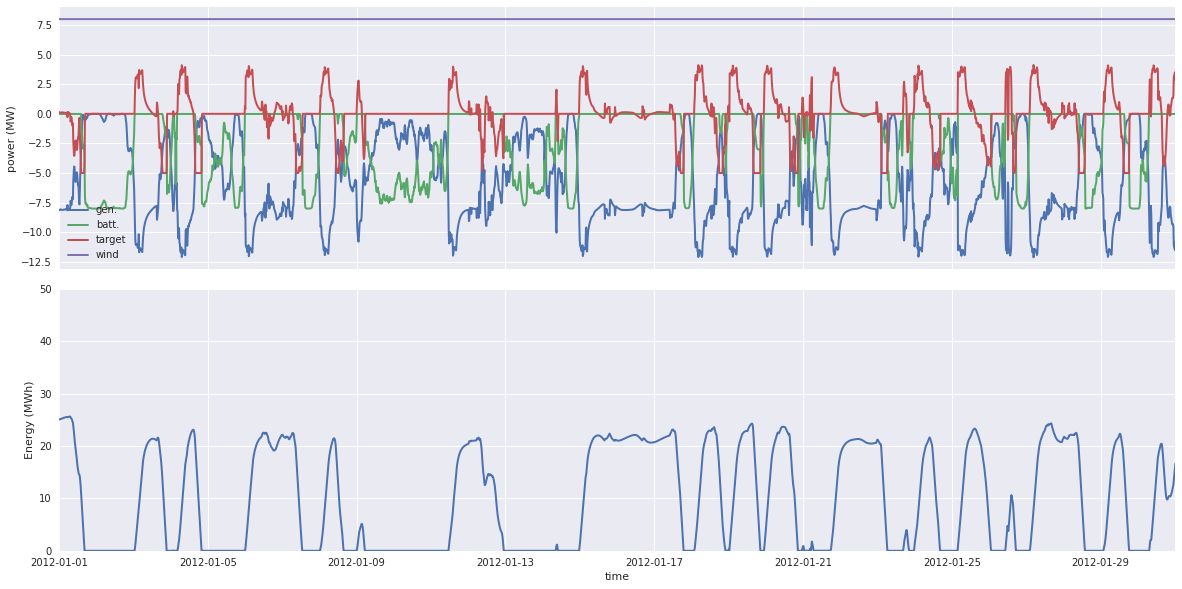

In [ ]:
plot(AR_MPC_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'AR_mpc')

### Diagnostic 

In [ ]:
# t = sim_start_time

# past = p_wind[t-intervals_per_day:t]
# future = p_wind[t:t+intervals_per_day]

# past_baseline = baseline[t-intervals_per_day:t]
# fut_baseline = baseline[t:t+intervals_per_day]

# past.plot()
# future.plot()

# past_baseline.plot()
# fut_baseline.plot()

# plt.figure()

# (past-  past_baseline).plot()
# (future-  fut_baseline).plot()

# pred = predict_wind(p_wind, baseline, autoreg_residual_params, t, intervals_per_day, intervals_per_day)

# (pred - fut_baseline).plot(style='--')

# plt.figure()
# past.plot()
# future.plot()
# (pred).plot()

NameError: ignored

## Robust MPC 

In [ ]:
T_MPC = intervals_per_day
K = 20

energy_stored = np.empty(T)

target_output_MPC, wind_power_available_MPC, initial_storage_MPC, final_storage_MPC, final_energy_price, MPC_network = \
    make_network(T_MPC, K)
    
initial_storage_MPC.value = np.matrix(initial_storage)
final_storage_MPC.value = np.matrix(initial_storage)
final_energy_price.value = np.matrix(MPC_final_energy_price)


def make_forecasts(t):
    target_output_MPC.value = np.tile(target_output[t:t+T_MPC], (K,1)).T
#     wind_power_available_MPC.value = np.tile(np.concatenate([
#         [p_wind[sim_start_time+t]],
#         predict_wind(p_wind, baseline, autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC)[:-1]]),
#                                              (K,1)).T
    # draw scenarios
    scenarios = np.hstack([np.matrix([p_wind[sim_start_time+t]]*K).T,
                           np.random.multivariate_normal(predict_wind(p_wind, baseline, 
                            autoreg_residual_params, sim_start_time+t+1, T_MPC, T_MPC), 
                             sigma_residual_errors, K)[:,:-1]])
    scenarios = np.maximum(wind_power_min, scenarios)
    scenarios = np.minimum(wind_power_max, scenarios)
    wind_power_available_MPC.value = scenarios.T
    
        
def implement(t):
    energy_stored[t] = MPC_network.devices[2].energy.value[0,0]
    initial_storage_MPC.value = np.matrix(energy_stored[t])
    
cost_robust_MPC, MPC_robust_results = \
    run_mpc(MPC_network, T, make_forecasts, implement, verbose = False, solver='ECOS')

100%|██████████| 2976/2976 [1:07:48<00:00,  1.38s/it]


(Values are daily averages.)

Energy sold:		192.00 MWh
Wind energy avail.:	202.36 MWh
Gas gener. output:	45.64 MWh
Wind energy used:	145.55 MWh
Wind energy lost:	56.81 MWh

Energy sold (at $80/MWh):    $15360.00
Cost of gas generated energy:  $3788.28


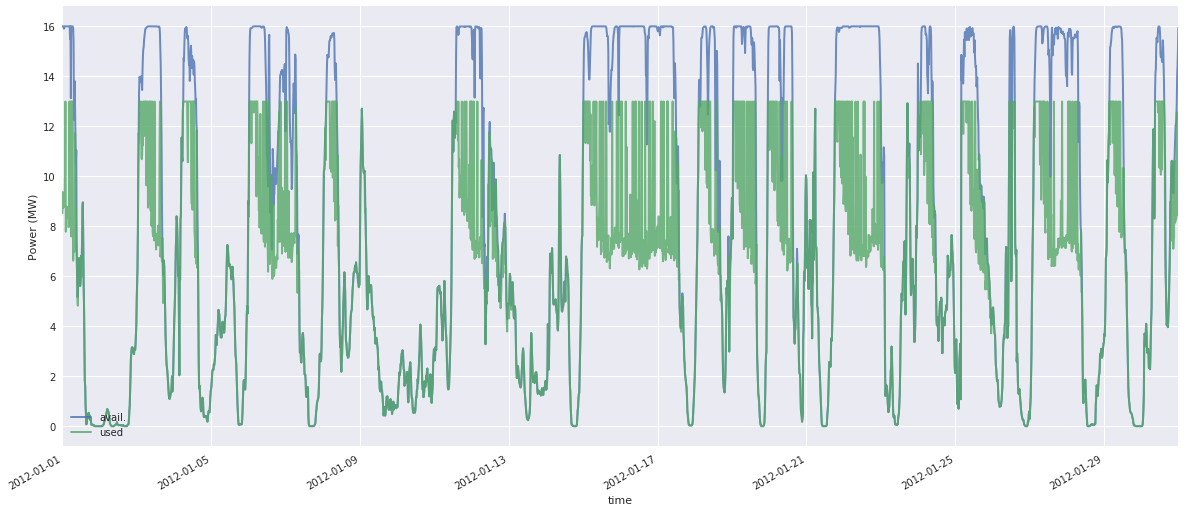

In [ ]:
wind_gen, gas_gen, storage = MPC_network.devices[0:3]

print_and_plot_stats(wind_power_avail =  p_wind[sim_start_time:sim_end_time], 
                     wind_power_used = -MPC_robust_results.power[(wind_gen, 0)].flatten(), 
                     gas_power = -MPC_robust_results.power[(gas_gen,0)].flatten(), 
                     output =  target_output[:T],
                     cost = cost_robust_MPC)

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


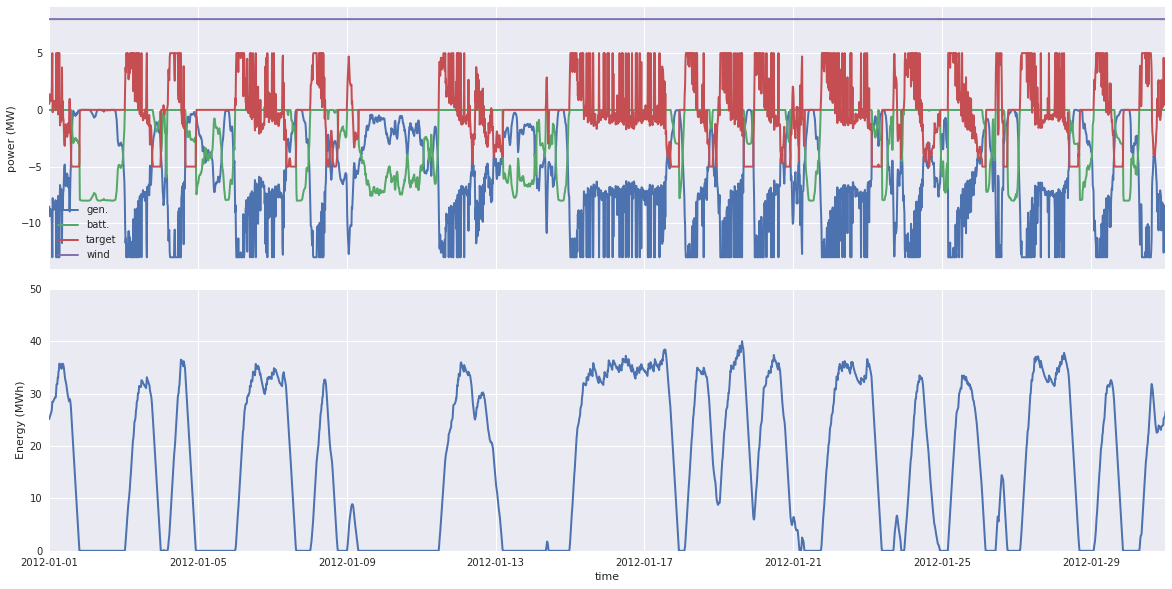

In [ ]:
plot(MPC_robust_results,  baseline[sim_start_time:sim_end_time], energy_stored, 'robust_mpc')